In [1]:
import tensorflow as tf
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
import random

2023-04-10 16:25:53.785251: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 16:25:54.451645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 16:26:04.293152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
class simple_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 10
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(input)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(batch_norm)
    output = tf.keras.layers.Dense(action_size, activation='linear')(dense2)
    return tf.keras.models.Model(inputs=input, outputs=output)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(state)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



In [32]:
#Environment Requirements for both deterministic and Stochastic
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, stochastic = False, max_timesteps = 10):
    '''
    # Initializes the class
    # Define action and observation space
    #We have an action space of 4 Discrete actions, namely,
      1. Up, action = 0
      2. Down, action = 1
      3. Right, action = 2
      4. Left, action = 3
    #We have an observation space of 16, 4x4 grid hence the no of states is 16  (minimun was 12)
    The environment has 3 bonus positions as well as 2 hole/pit positions 
    # the numbers 1 and 0.5 for the state position are for visualizations
    #
    '''
    self.observation_space = gym.spaces.Discrete(16)
    self.action_space = gym.spaces.Discrete(4)
    self.max_timesteps = max_timesteps
    self.observation_space.low, self.observation_space.high = 0,4
    self.stochastic = stochastic
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,2]
    self.bonus1_pos = [0,3]
    self.bonus2_pos = [1,2]
    self.bonus3_pos = [2,3]
    self.timestep = 0
    self.state = np.zeros((4,4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
  def reset(self, **kwargs):
    '''
    Reset the environment to initial state.

    '''
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,2]
    self.bonus1_pos = [0,3]
    self.bonus2_pos = [1,2]
    self.bonus3_pos = [2,3]
    self.state = np.zeros((4, 4))
    self.pos_dict = {}
    for i in range(4):
      for j in range(4):
        self.pos_dict[4*i+j] = [i,j]
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.agent_pos
    info = {}
    return observation,info


  def render(self):
    '''
    Render the GridEnvironment
    '''
    plt.imshow(self.state)
  
  
  def step(self, action):
    '''
    Define an execution of one timestep within the environment
    input :action: action from the action space [0,1,2,3]
    outputs :observation, reward, terminated, truncated, info
    '''
    info = {}
    reward=0
    old_pos = self.agent_pos
    old_dist = np.sqrt(np.sum(np.square(np.array(old_pos)-np.array(self.goal_pos))))

    # It adds a level of uncertainity to the environment
    if(self.stochastic):
      info['action_given'] = action
      if (np.random.uniform(0,1)>0.75):
        action = action
      else:
        action = self.action_space.sample()
      info['action_taken'] = action

    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    a,b= np.clip(self.agent_pos[0], 0, 3), np.clip(self.agent_pos[1], 0, 3)
    if a!=self.agent_pos[0]:
      reward-=1
    if b!=self.agent_pos[1]:
      reward-=1
    self.agent_pos[0] = a
    self.agent_pos[1] = b
    self.agent_pos = np.array(self.agent_pos)

    self.state = np.zeros((4,4))
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.agent_pos)] = 1


    observation = self.state.flatten()
    
    new_dist = np.sqrt(np.sum(np.square(np.array(self.agent_pos)-np.array(self.goal_pos))))
    
    proximity = True
    if (old_dist-new_dist<0):
      reward = -1
      proximity = False
    elif (old_dist-new_dist==0):
      reward = 0
    else:
      reward = +1

    if (self.agent_pos == self.goal_pos).all():
      reward+= 10 
      self.state[tuple(self.goal_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus2_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus3_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus3_pos)]=self.state[tuple(self.agent_pos)]
    elif(self.agent_pos == self.hole2_pos).all():
      reward-=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward-=3
      self.state[tuple(self.hole2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus1_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus1_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.hole1_pos).all():
      reward-=5
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.75):
          reward-=3
      self.state[tuple(self.hole1_pos)]=self.state[tuple(self.agent_pos)]
   
    observation = self.agent_pos

    self.timestep += 1
    terminated = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

    return observation, reward, terminated, truncated, info



100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


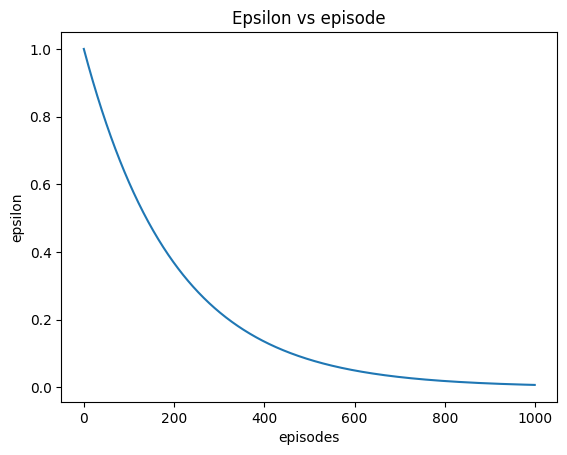

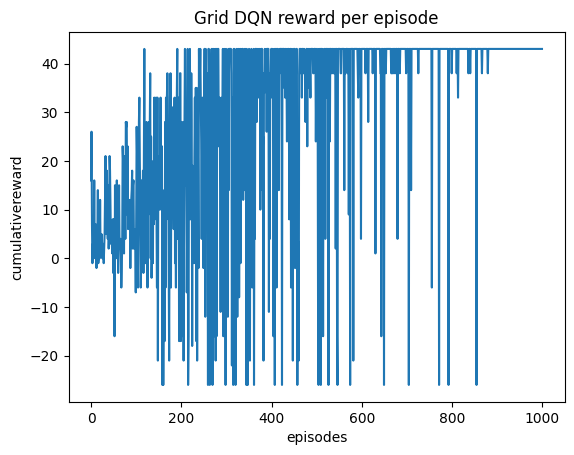

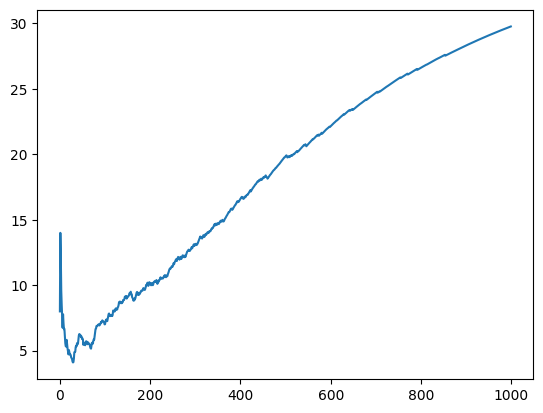

In [33]:
#Train the Grid World Environment using DQN 
env = GridEnvironment()
agent = simple_dqn(env,2,4)
#agent.load('grid-dqn.h5')
episodes = 1000
timesteps = 50
cumulativegraph = []
epsilon = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent.act(env.agent_pos,2)
    state1 = np.copy(env.agent_pos)
    observation, reward, terminated, truncated, info = env.step(action)
    state2 = np.copy(env.agent_pos)
    agent.store(state1, action, reward,state2,terminated)
    cumulative_reward += reward
    if (j%20==0): agent.replay()
    if terminated: break
  epsilon.append(agent.epsilon)
  if i%10==0:
    agent.save('grid-dqn.h5')
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
  if agent.epsilon > agent.epsilon_min:
    agent.epsilon *= agent.epsilon_decay
  cumulativegraph.append(cumulative_reward)
agent.save('grid-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:00<00:00, 31.80it/s]


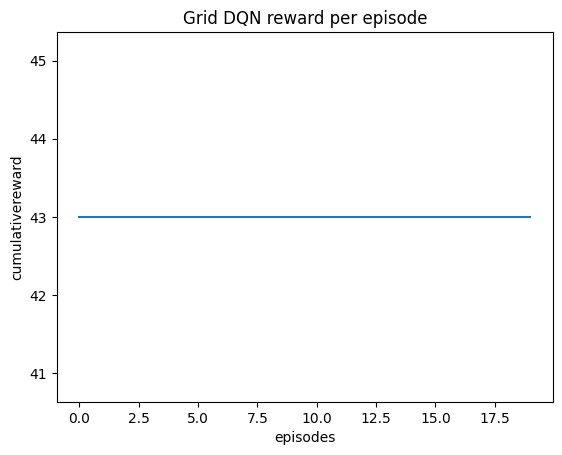

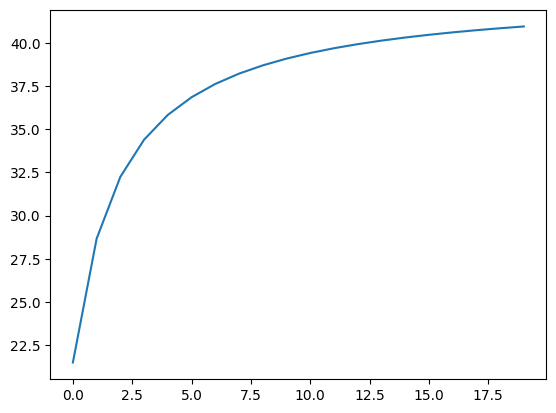

In [35]:
#Testing trained Grid World on DQN environment
episodes = 20
timesteps = 50
cumulativegraph = []
epsilon = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action= agent.act(env.agent_pos,2,False)
    state1 = np.copy(env.agent_pos)
    observation, reward, terminated, truncated, info = env.step(action)
    state2 = np.copy(env.agent_pos)
    agent.store(state1, action, reward,state2,terminated)
    cumulative_reward += reward
    if terminated: break
  epsilon.append(agent.epsilon)
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

In [43]:
class dueling_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 10
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(input)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(batch_norm)
    value, advantage = tf.keras.layers.Dense(1,activation='linear')(dense2), tf.keras.layers.Dense(action_size,activation='linear')(dense2)
    q = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
    return tf.keras.models.Model(inputs=input, outputs=q)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(state)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


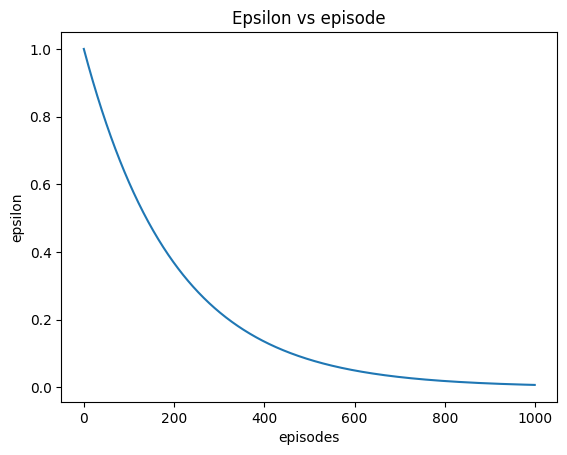

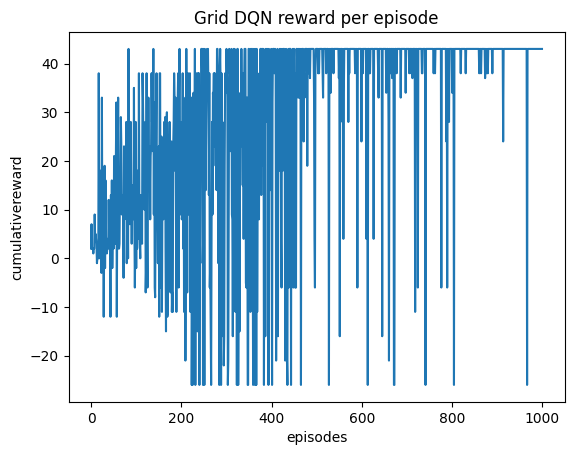

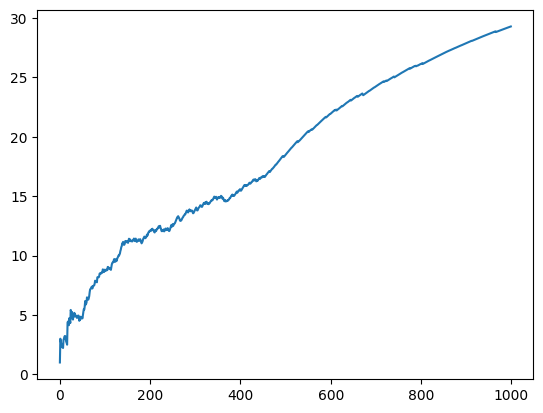

In [44]:
#Train the Grid World Environment using dueling DQN 
env = GridEnvironment()
agent = dueling_dqn(env,2,4)
#agent.load('grid-dueling-dqn.h5')
episodes = 1000
timesteps = 50
cumulativegraph = []
epsilon = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent.act(env.agent_pos,2)
    state1 = np.copy(env.agent_pos)
    observation, reward, terminated, truncated, info = env.step(action)
    state2 = np.copy(env.agent_pos)
    agent.store(state1, action, reward,state2,terminated)
    cumulative_reward += reward
    if (j%20==0): agent.replay()
    if terminated: break
  epsilon.append(agent.epsilon)
  if i%10==0:
    agent.save('grid-dueling-dqn.h5')
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
  if agent.epsilon > agent.epsilon_min:
    agent.epsilon *= agent.epsilon_decay
  cumulativegraph.append(cumulative_reward)
agent.save('grid-dueling-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


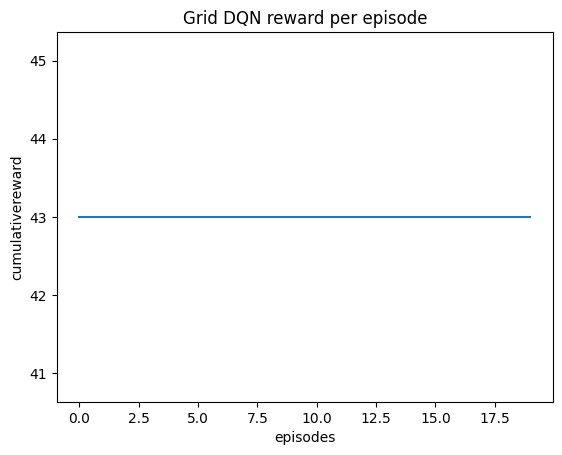

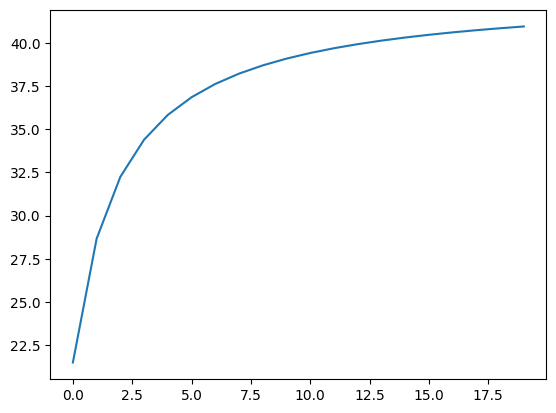

In [46]:
#Testing trained Grid World on DQN environment
episodes = 20
timesteps = 50
cumulativegraph = []
epsilon = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action= agent.act(env.agent_pos,2,False)
    state1 = np.copy(env.agent_pos)
    observation, reward, terminated, truncated, info = env.step(action)
    state2 = np.copy(env.agent_pos)
    agent.store(state1, action, reward,state2,terminated)
    cumulative_reward += reward
    if terminated: break
  epsilon.append(agent.epsilon)
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

In [47]:
class simple_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 10
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense1 = tf.keras.layers.Dense(256, activation='relu')(input)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(batch_norm)
    output = tf.keras.layers.Dense(action_size, activation='linear')(dense2)
    return tf.keras.models.Model(inputs=input, outputs=output)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(state)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



2


100%|██████████| 1000/1000 [57:45<00:00,  3.47s/it]


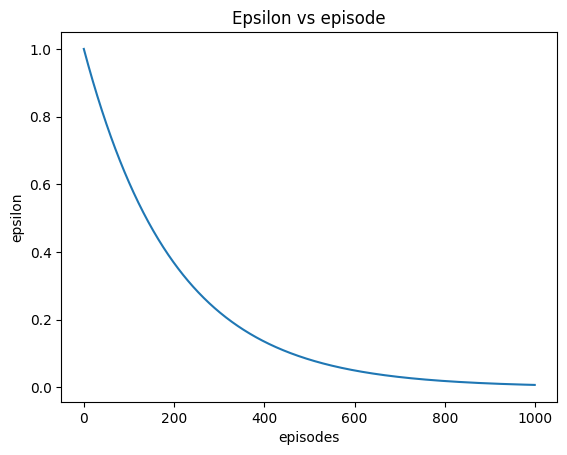

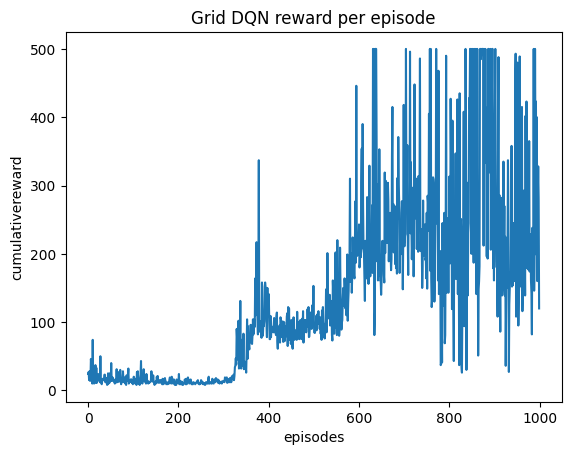

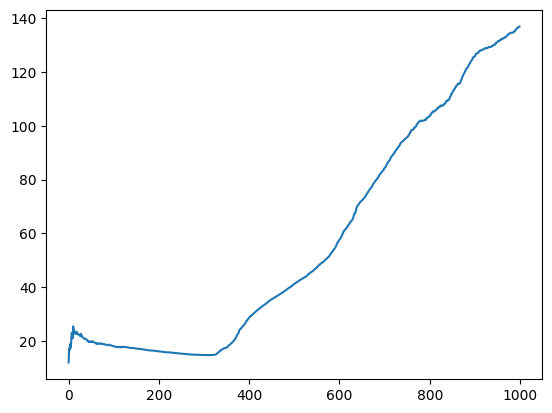

In [56]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(action_size)
agent = simple_dqn(env,state_size,action_size)
episodes = 1000
timesteps = 500
cumulativegraph = []
epsilon = []
avg_reward = [0]
#agent.load('cartpole-dqn.h5')
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent.act(state,state_size)
    next_state, reward,terminated, truncated, info = env.step(action)
    agent.store(state, action, reward,next_state,terminated)
    state = next_state
    cumulative_reward += reward
    if j%10==0: agent.replay()
    if terminated: break
  epsilon.append(agent.epsilon)
  agent.replay()
  if i%10==0:
        agent.save('cartpole-dqn.h5')
        tf.keras.backend.clear_session()
  if agent.epsilon > agent.epsilon_min:
    agent.epsilon *= agent.epsilon_decay
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
agent.save('cartpole-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:00<00:00, 27.49it/s]


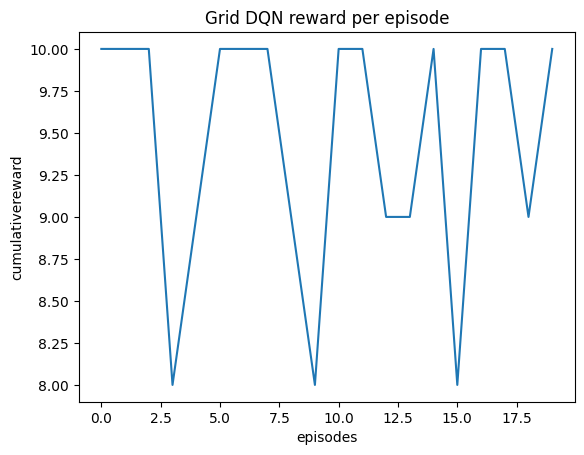

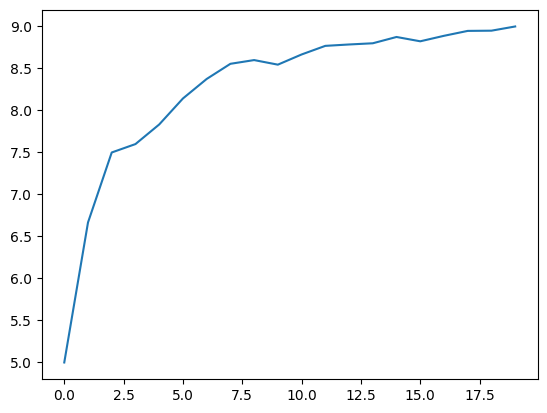

In [60]:
episodes = 20
timesteps = 500
cumulativegraph = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent.act(state,state_size,train=False)
    next_state, reward,terminated, truncated, info = env.step(action)
    state = next_state
    cumulative_reward += reward
    if terminated: break
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

In [14]:
class dueling_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.9995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 10
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(input)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(batch_norm)
    dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
    value, advantage = tf.keras.layers.Dense(1,activation='linear')(dense3), tf.keras.layers.Dense(action_size,activation='linear')(dense3)
    q = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
    return tf.keras.models.Model(inputs=input, outputs=q)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(agent_position)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



2


100%|██████████| 1000/1000 [15:40<00:00,  1.06it/s]


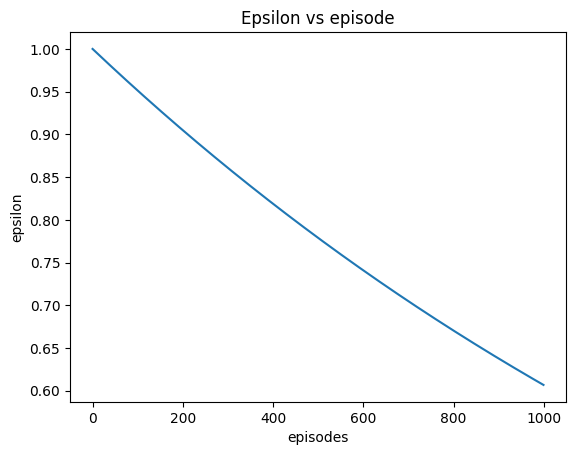

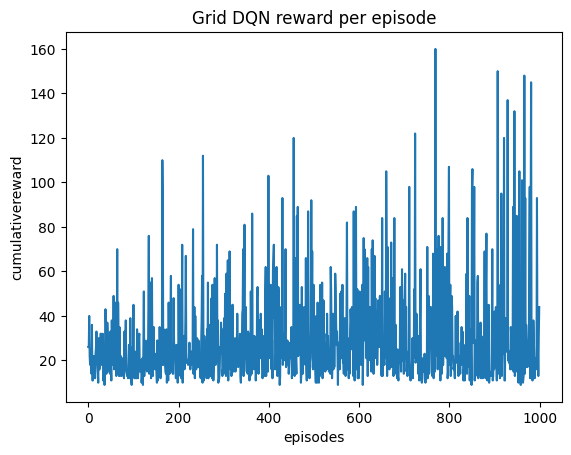

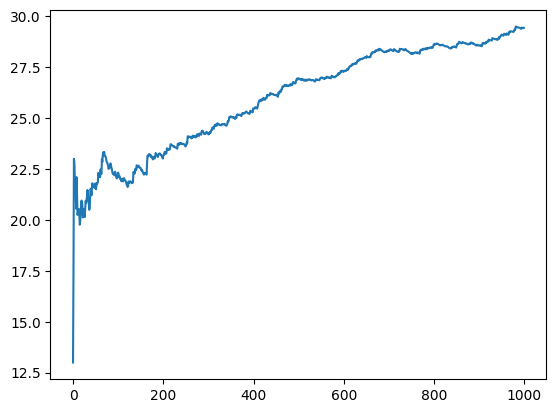

In [17]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(action_size)
agent1 = dueling_dqn(env,state_size,action_size)
episodes = 1000
timesteps = 500
cumulativegraph = []
epsilon = []
avg_reward = [0]
agent1.load('cartpole-dueling-dqn.h5')
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent1.act(state,state_size)
    next_state, reward,terminated, truncated, info = env.step(action)
    agent1.store(state, action, reward,next_state,terminated)
    state = next_state
    cumulative_reward += reward
    if j%10==0: agent1.replay()
    if terminated: break
  epsilon.append(agent1.epsilon)
  agent1.replay()
  if i%10==0:
        agent1.save('cartpole-dueling-dqn.h5')
        tf.keras.backend.clear_session()
  if agent1.epsilon > agent1.epsilon_min:
    agent1.epsilon *= agent1.epsilon_decay
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
agent1.save('cartpole-dueling-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


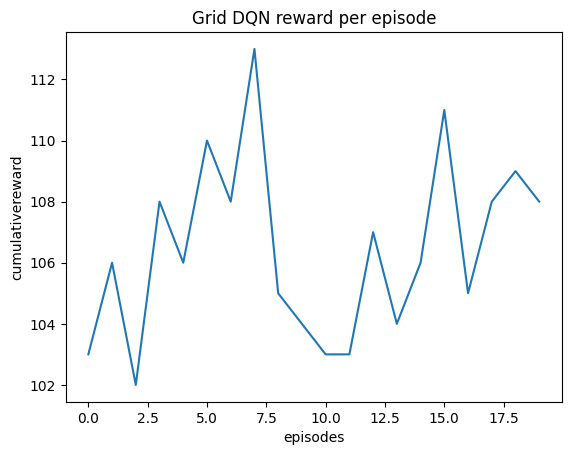

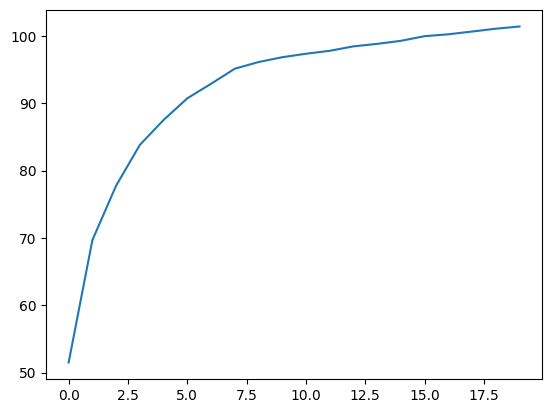

In [18]:
episodes = 20
timesteps = 500
cumulativegraph = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    action = agent1.act(state,state_size,train=False)
    next_state, reward,terminated, truncated, info = env.step(action)
    state = next_state
    cumulative_reward += reward
    if terminated: break
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

In [9]:
class simple_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 5
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense = tf.keras.layers.Dense(64, activation='relu')(input)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(dense)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(batch_norm)
    output = tf.keras.layers.Dense(action_size, activation='linear')(dense2)
    return tf.keras.models.Model(inputs=input, outputs=output)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(agent_position)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s]


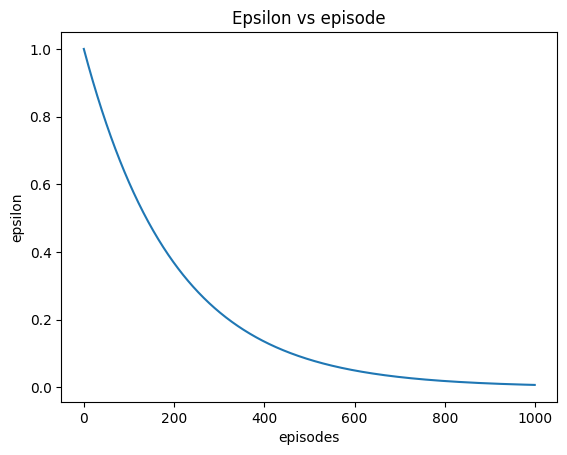

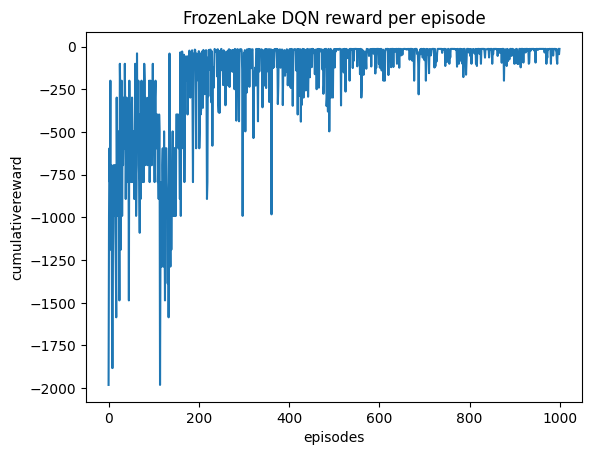

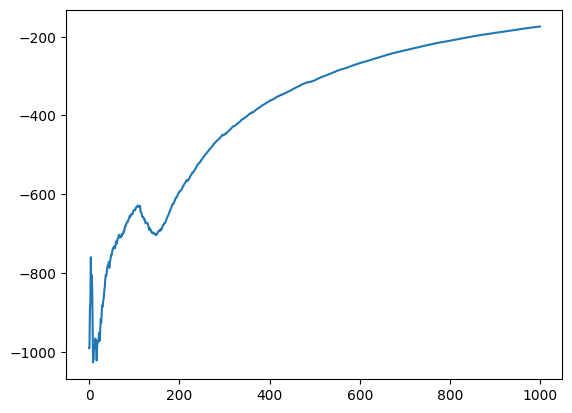

In [12]:
env = gym.make("CliffWalking-v0")
state_size = (env.observation_space.n,)
action_size = env.action_space.n
agent = simple_dqn(env,state_size,action_size)
episodes = 1000
timesteps = 100
cumulativegraph = []
epsilon = []
avg_reward = [0]
#agent.load('CliffWalking-dqn.h5')
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    state_to_send = np.zeros(state_size)
    state_to_send[state] = 1
    action = agent.act(state_to_send,state_size)
    next_state, reward,terminated, truncated, info = env.step(action)
    next_state_to_send = np.zeros(state_size)
    next_state_to_send[next_state] = 1
    agent.store(state_to_send, action, reward,next_state_to_send,terminated)
    state = next_state
    cumulative_reward += reward
    if j%10==0: agent.replay()
    if terminated: break
  epsilon.append(agent.epsilon)
  agent.replay()
  if i%10==0:
        agent.save('CliffWalking-dqn.h5')
        tf.keras.backend.clear_session()
  if agent.epsilon > agent.epsilon_min:
    agent.epsilon *= agent.epsilon_decay
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
agent.save('CliffWalking-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('FrozenLake DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


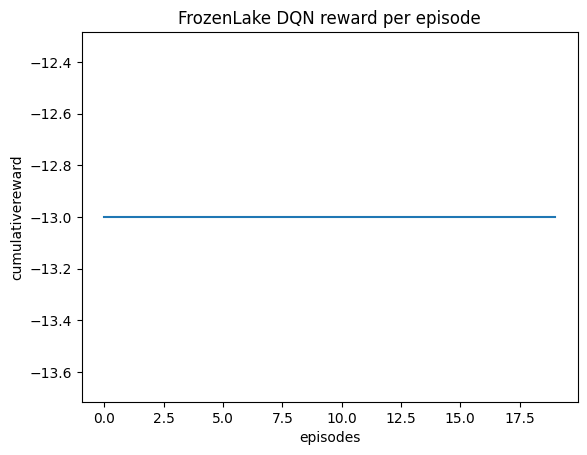

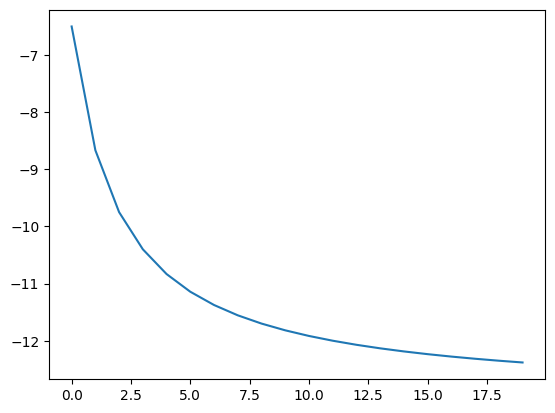

In [13]:
episodes = 20
timesteps = 500
cumulativegraph = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    state_to_send = np.zeros(state_size)
    state_to_send[state] = 1
    action = agent.act(state_to_send,state_size,train=False)
    next_state, reward,terminated, truncated, info = env.step(action)
    state = next_state
    cumulative_reward += reward
    if terminated: break
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('FrozenLake DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

In [9]:
print( env.observation_space.shape)

(4,)


In [16]:
class dueling_dqn:
  def __init__(self,env,state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.9995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 5
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = tf.keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    dense1 = tf.keras.layers.Dense(64, activation='relu')(input)
    batch_norm = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm)
    dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
    value, advantage = tf.keras.layers.Dense(1,activation='linear')(dense3), tf.keras.layers.Dense(action_size,activation='linear')(dense3)
    q = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
    return tf.keras.models.Model(inputs=input, outputs=q)
  # take action using the step function
  def act(self,agent_position,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(agent_position)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
       self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)
    
    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = self.model(np.array(state1))

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)  



100%|██████████| 1000/1000 [27:52<00:00,  1.67s/it]


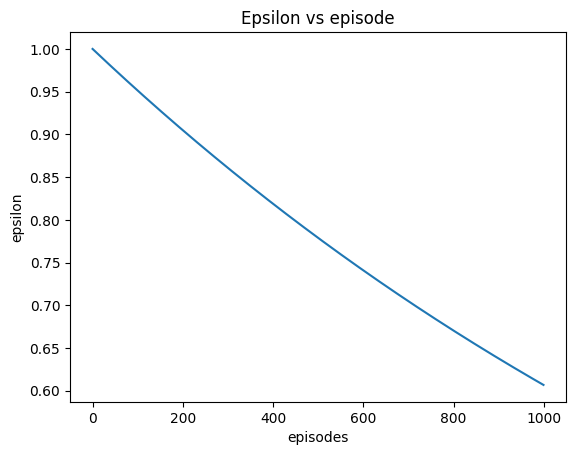

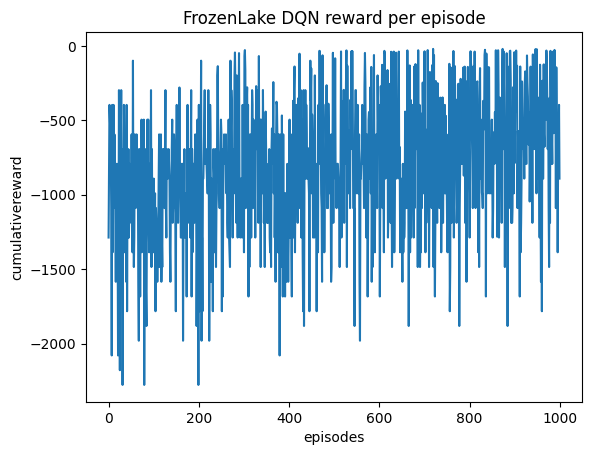

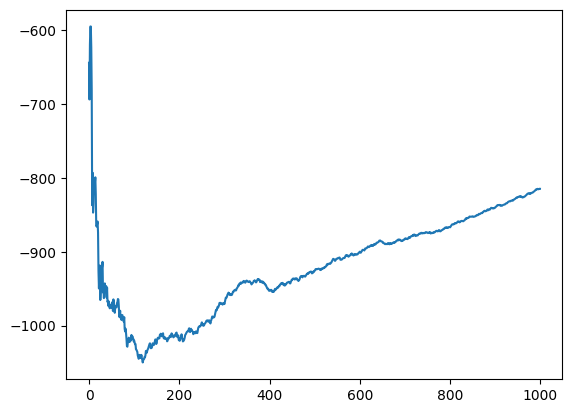

In [17]:
env = gym.make("CliffWalking-v0")
state_size = (env.observation_space.n,)
action_size = env.action_space.n
agent = dueling_dqn(env,state_size,action_size)
episodes = 1000
timesteps = 100
cumulativegraph = []
epsilon = []
avg_reward = [0]
#agent.load('CliffWalking-dueling-dqn.h5')
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    state_to_send = np.zeros(state_size)
    state_to_send[state] = 1
    action = agent.act(state_to_send,state_size)
    next_state, reward,terminated, truncated, info = env.step(action)
    next_state_to_send = np.zeros(state_size)
    next_state_to_send[next_state] = 1
    agent.store(state_to_send, action, reward,next_state_to_send,terminated)
    state = next_state
    cumulative_reward += reward
    if j%10==0: agent.replay()
    if terminated: break
  epsilon.append(agent.epsilon)
  agent.replay()
  if i%10==0:
        agent.save('CliffWalking-dueling-dqn.h5')
        tf.keras.backend.clear_session()
  if agent.epsilon > agent.epsilon_min:
    agent.epsilon *= agent.epsilon_decay
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))
agent.save('CliffWalking-dueling-dqn.h5')
plt.plot(epsilon)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

plt.plot(cumulativegraph)
plt.title('FrozenLake DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()

100%|██████████| 20/20 [00:01<00:00, 15.93it/s]


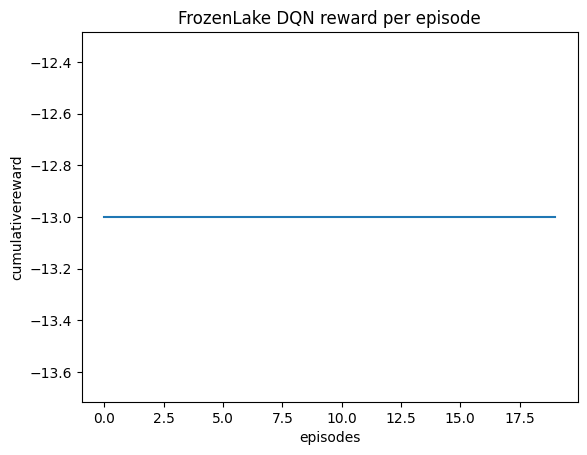

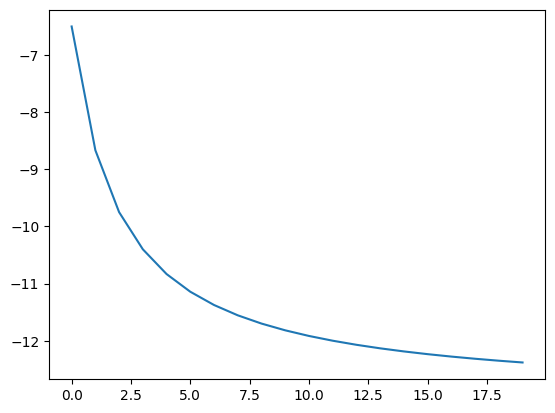

In [18]:
episodes = 20
timesteps = 500
cumulativegraph = []
avg_reward = [0]
for i in tqdm(range(0,episodes)):
  termination = False
  state, info = env.reset()
  cumulative_reward=0
  for j in range(0,timesteps):
    state_to_send = np.zeros(state_size)
    state_to_send[state] = 1
    action = agent.act(state_to_send,state_size,train=False)
    next_state, reward,terminated, truncated, info = env.step(action)
    state = next_state
    cumulative_reward += reward
    if terminated: break
  cumulativegraph.append(cumulative_reward)
  avg_reward.append((avg_reward[-1]*len(avg_reward)+cumulative_reward)/(len(avg_reward)+1))

plt.plot(cumulativegraph)
plt.title('FrozenLake DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(avg_reward[1:])
plt.show()